In [4]:
import pandas
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

constant_width = 60
roi_output_dir = "output/trial_1/rois"

# read the csv file
df = pandas.read_csv('081624_roi_metadata_mod.csv')
df.head()

rois = []
rois_slice = []
chosen_strip_numbers = [101, 106, 134, 135, 161, 176, 187, 229, 232]

# sort the df rows by the 'strip' column, so that the strips are in order
# Thse are numeric, so treat them as such
df['strip'] = df['strip'].astype(int)
df = df.sort_values('strip')

# df adjusted, make sure x2 is 60 pixels more than x1
df['x2'] = df['x1'] + constant_width

# iterate through the rows of the datafare
for i, row in df.iterrows():
    
    if row['strip'] not in chosen_strip_numbers:
        continue 
    else:
        print(f"Processing strip {row['strip']}, filename {row['filename']}")
    
    image = cv2.imread(row['filename'])
    
    # use the x and y coordinates to draw a rectangle around the ROI
    box_size = row['box_size'] * 2
    x = int(row['x'] - box_size / 2)
    y = int(row['y'] - box_size / 2)
    slice_x1, slice_y1, slice_x2, slice_y2 = row['x1'], row['y1'], row['x2'], row['y2']

    # if any of the x, y, slice_x1, slice_y1, slice_x2, slice_y2 are negative, skip this row
    if x < 0 or y < 0 or slice_x1 < 0 or slice_y1 < 0 or slice_x2 < 0 or slice_y2 < 0:
        continue

    # crop the image to the ROI
    roi = image[y:y+box_size, x:x+box_size]

    # rotate the image by the rotation angle
    rotation_matrix = cv2.getRotationMatrix2D((box_size/2, box_size/2), row['rotation_angle'], 1)
    roi = cv2.warpAffine(roi, rotation_matrix, (box_size, box_size))

    # crop back to the original size
    roi = roi[int(box_size/4):int(box_size*3/4), int(box_size/4):int(box_size*3/4)]

    # make a slice of the roi, (slice_x1, slice_y1), (slice_x2, slice_y2), then save it to the rois folder
    os.makedirs(roi_output_dir, exist_ok=True)
    roi_slice = roi[slice_y1:slice_y2, slice_x1:slice_x2].copy()
    cv2.imwrite(f'{roi_output_dir}/strip_{row["strip"]}.png', roi_slice)

    # draw the rectangle on the roi
    cv2.rectangle(roi, (slice_x1, slice_y1), (slice_x2, slice_y2), (0, 255, 0), 2)

    # add the i and the label to the image
    cv2.putText(roi, f'{row["strip"]}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # add the images to the roi list
    rois.append(roi)
    rois_slice.append(roi_slice)

# create a slice of the dataframe with only the chosen strip numbers
df = df[df['strip'].isin(chosen_strip_numbers)]

# save the dataframe to a csv file
df.to_csv('rois_metadata_bignine.csv', index=False)


Processing strip 101, filename ./raw_images/2023-7-26_Wild Type_500uE 1 hour_3_024_19k.png
Processing strip 106, filename ./raw_images/2023-9-4_Wild Type_Dark Adapted_1_004_25k.png
Processing strip 134, filename ./raw_images/2023-9-4_Wild Type_Dark Adapted_3_012_25k.png
Processing strip 135, filename ./raw_images/2023-9-4_Wild Type_Dark Adapted_3_012_25k.png
Processing strip 161, filename ./raw_images/2023-2-14_Wild Type_Dark Adapted_1_013_19k.png
Processing strip 176, filename ./raw_images/2023-2-14_Wild Type_Dark Adapted_1_025_19k.png
Processing strip 187, filename ./raw_images/2023-2-14_Wild Type_Dark Adapted_2_014_19k.png
Processing strip 229, filename ./raw_images/2023-9-4_Wild Type_Dark Adapted_1_004_25k.png
Processing strip 232, filename ./raw_images/2023-9-4_Wild Type_Dark Adapted_1_006_19k.png


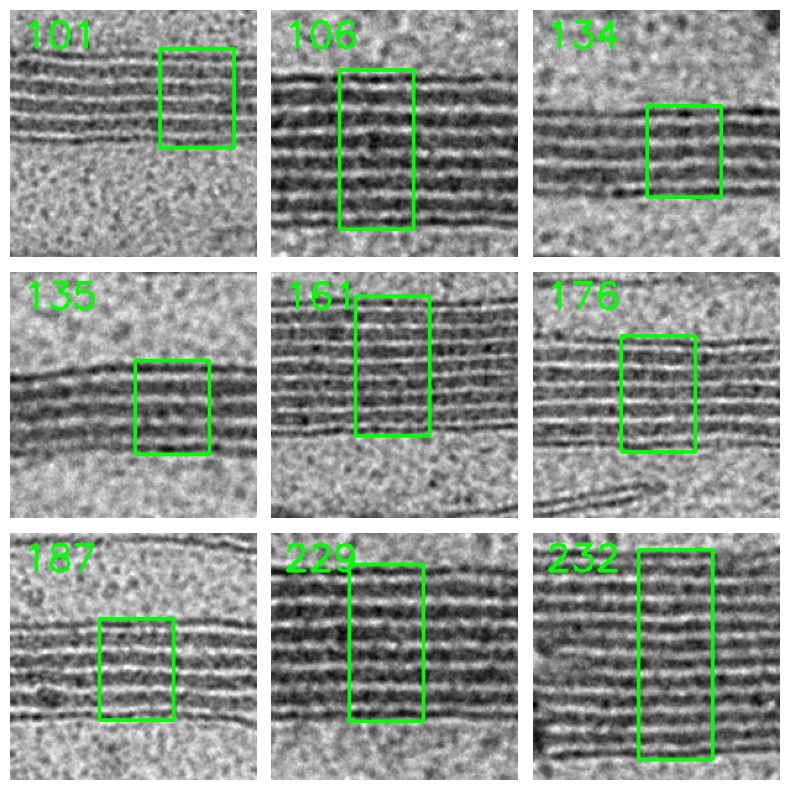

In [2]:
# num images per row
n_images_per_row = 3

# Increase the figsize to make the images larger
plt.figure(figsize=(8, 8)) 

# figure out how many rows we need, with 5 images per row
n_rows = len(rois) // n_images_per_row

# if there are any remaining images, add an extra row
if len(rois) % n_images_per_row != 0:
    n_rows += 1
    
# the images are too small! Lets make sure the image is larger
for i, roi in enumerate(rois):
    plt.subplot(n_rows, n_images_per_row, i+1)
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.tight_layout()

# Adjust the layout to have more space around images
# plt.subplots_adjust(wspace=-0.85, hspace=0.2)
plt.savefig('sorted_rois.png')

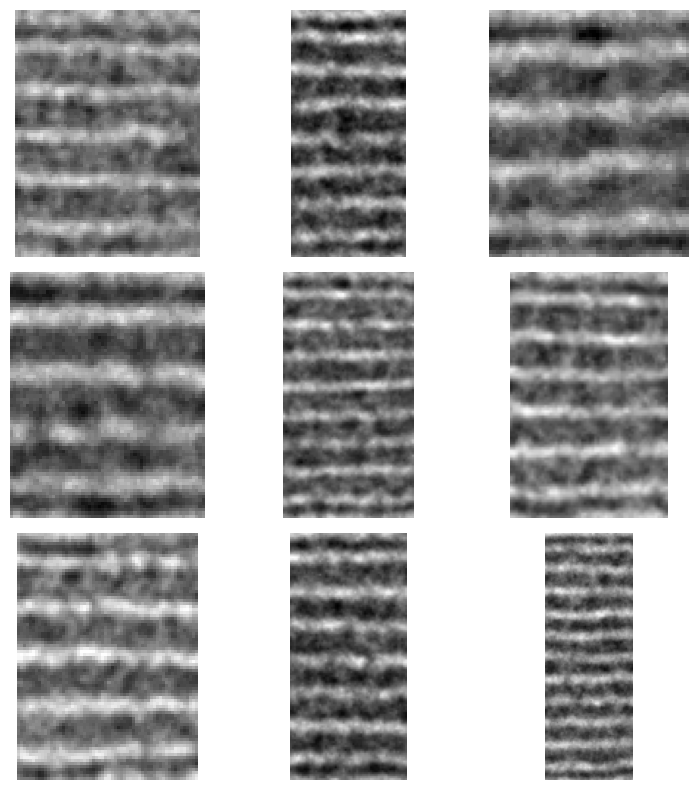

In [3]:
# num images per row
n_images_per_row = 3

# Increase the figsize to make the images larger
plt.figure(figsize=(8, 8)) 

# figure out how many rows we need, with 5 images per row
n_rows = len(rois_slice) // n_images_per_row

# if there are any remaining images, add an extra row
if len(rois_slice) % n_images_per_row != 0:
    n_rows += 1
    
# the images are too small! Lets make sure the image is larger
for i, roi in enumerate(rois_slice):
    plt.subplot(n_rows, n_images_per_row, i+1)
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.tight_layout()

# Adjust the layout to have more space around images
# plt.subplots_adjust(wspace=-0.85, hspace=0.2)
plt.savefig('sorted_rois_slice.png')